- Looking at which person has the highest similarity scores with the main user.
- one disadvantage is that I am assuming the main user stays the same (for example word selections). And there is a class imbalance because the total amount of text from the main user is significantly higher than any other messages sent by other users


In [1]:
import sklearn
from __future__ import print_function
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import pandas as pd
import numpy as np
import gensim
from gensim import corpora

import matplotlib.pyplot as mlt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/csv/FB_11_26_6.csv")

In [3]:
df.head(2)

,Unnamed: 0,thread#,user,message_x,Year,Month,Hour,Min,convo_style,Length,ttl_msg
0,0,0,mainuser,http://www.scoutzie.com/,2012,2,16,54,private,24,4606.0
1,1,0,mainuser,how'd you find it?,2012,2,16,53,private,18,4606.0


In [4]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)


In [6]:
import re
replaced_word = re.compile('(Main_User | mainuser)')
df['message'] = df.message.map(lambda x: replaced_word.sub('', x))

#groupby_user_msg.message.map(lambda x: "mainuser" if  else x)

In [36]:
df.tail(5)

,thread#,user,Year,Month,Hour,Min,convo_style,Length,ttl_msg,message
670512,8205,mainuser,2011,10,23,15,group/other,43,9935.0,but you've gotta start the other way around
670513,8205,mainuser,2011,10,23,15,group/other,52,9935.0,"Ah, that's a good way to make friends out of e..."
670514,8205,Person_1902,2011,10,23,15,group/other,42,9935.0,like i call everyone out on their bullshit
670515,8205,Person_1902,2011,10,23,15,group/other,38,9935.0,because I call her out on her bullshit
670516,8205,mainuser,2011,10,23,15,group/other,5,9935.0,I see


In [8]:
df.drop(['message_x'], axis = 1, inplace = True)


In [9]:
#removing msg sent before 2011
df[df.Year < 2011].message.count()
#removing 14646 rows

14646

In [11]:
#removing msg sent before 2011
after2010 = df[df.Year > 2010]


In [13]:
more_than_20 = after2010.groupby(['user']).message.count()[after2010.groupby(['user']).message.count() > 20]

In [15]:
more_than_20.tail()

user
Person_988        94
Person_990        71
Person_994       148
Person_997       265
mainuser      365155
Name: message, dtype: int64

In [16]:
df_20 = pd.DataFrame(more_than_20).reset_index()


In [27]:
df_20.head(2)

,user,message
0,100000098071661@facebook.com,34
1,100000582537251@facebook.com,26


In [17]:
df_20msg = df.merge(df_20, on='user', how='inner')

In [18]:
df_20msg.head(2)

,thread#,user,Year,Month,Hour,Min,convo_style,Length,ttl_msg,message_x,message_y
0,0,mainuser,2012,2,16,54,private,24,4606.0,http://www.scoutzie.com/,365155
1,0,mainuser,2012,2,16,53,private,18,4606.0,how'd you find it?,365155


In [19]:
df_20msg.rename(columns={'message_x':'message', 'message_y':'#msg'}, inplace=True)

In [183]:
import cPickle
f = open('/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/csv/fb_in_out_12_3.p', 'w')
cPickle.dump(df_20msg, f)
f.close()

In [41]:
def remove_emojis(msg): #input: string
    msg = msg.decode('utf_8')
    try:
        # Wide UCS-4 build
        myre = re.compile(u'['
            u'\U0001F300-\U0001F64F'
            u'\U0001F680-\U0001F6FF'
            u'\u2600-\u26FF\u2700-\u27BF]+', 
            )
        return myre.sub('', msg)
    except re.error:
        # Narrow UCS-2 build
        myre = re.compile(u'('
            u'\ud83c[\udf00-\udfff]|'
            u'\ud83d[\udc00-\ude4f\ude80-\udeff]|'
            u'[\u2600-\u26FF\u2700-\u27BF])+', 
            )
        return myre.sub('', msg)
    #returns unicode

In [42]:
from tweetokenize import Tokenizer
tweetken = Tokenizer(usernames = False, allcapskeep = False, 
                     urls ='', hashtags='',phonenumbers='',times='',numbers='',
                     ignorestopwords = True, normalize = 1)

#stopwords: If C{True}, will remove any stopwords. 
#The default set includes 'I', 'me', 'itself', 'against', 'should', etc.
# IMPORTANT ***so keep in mind to do featue engineering aka quantifying text before removing stopwords***

from nltk.stem import SnowballStemmer
custom_punc = '?!"#$%&\'<*>+,-).=@[\\]:(^_`/{|}~'


stemmer = SnowballStemmer('english')

def pre_processing(message): #input: unicode
    removed = remove_emojis(message) #returns unicode
    token_list = tweetken.tokenize(removed) #tweet-tokenizer. return a list of unicode
    token_list2 = [re.sub(u'[^a-zA-Z]+', ' ', x) for x in token_list] #remove everything but letters
    
    output = map(lambda x: stemmer.stem(x), token_list2) # stemming
    # LDA is not working well with stemmer because it takes away some information
    
    output = [''.join(c for c in s if c not in custom_punc) for s in output] #remove punctuations 
    #output = [s for s in output if s] #not sure what this is doing here
    output = ' '.join(output) #join list back to string
    return output #return unicode
    

In [52]:
pre_processing('http://www.facebook.com/')
#it doesn't actually clean links very well

u'http     w   facebook   com  '

In [43]:
# pivot to each person represents a document of text
groupby_user_msg = pd.DataFrame(pd.pivot_table(df_20msg, values = 'message', index = 'user', aggfunc=lambda x: ' '.join(x)))

In [44]:
groupby_user_msg.reset_index(inplace=True)

In [45]:
groupby_user_msg.head(2)

,user,message
0,100000098071661@facebook.com,"Thanks, frand ^_^ Thank you for sharing! Will ..."
1,100000582537251@facebook.com,Never underestimate the ability of people to w...


In [46]:
processed_msg = groupby_user_msg.message.map(pre_processing)
%time

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [48]:
groupby_user_msg.tail()

,user,message
1186,Person_988,"Ofcourse, if there's anything you wanna ask me..."
1187,Person_990,yeah a link for the complete batch would be ni...
1188,Person_994,even we are still gonna take a break for both ...
1189,Person_997,I'm about to leave. Where are you so I can ret...
1190,mainuser,http://www.scoutzie.com/ how'd you find it? I'...


In [53]:
processed_df = groupby_user_msg.merge(pd.DataFrame(processed_msg), how = 'right', left_index= True, right_index=True)

In [54]:
processed_df.drop(['message_x'], axis =1, inplace=True)

In [55]:
processed_df.rename(columns={'message_y':'message'}, inplace=True)

In [56]:
processed_df.head()

,user,message
0,100000098071661@facebook.com,thank frand thank share watch respond ...
1,100000582537251@facebook.com,never underestim abil peopl work interest lmao...
2,100000674728220@facebook.com,cool look forward i m free tonight pleas l...
3,100000754500139@facebook.com,thought kane request specif hs educ us resp...
4,100001024680680@facebook.com,also thank main user like yeah haha ...


In [57]:
def remove_one_letter(msg):
    msg_list = []   
    for word in msg.split():
        if len(word)>2:
            msg_list.append(word)
        else:
            continue
    return msg_list

In [58]:
msg_clean1 = processed_df.message.apply(remove_one_letter)

In [59]:

processed_df.message = msg_clean1

In [60]:
msg_clean1.tail(2)

1189    [leav, return, charger, isn, best, love, lmk, ...
1190    [http, scoutzi, com, how, find, look, tracebac...
Name: message, dtype: object

In [61]:
from nltk.corpus import stopwords
#customising a list of stopwords with nltk stopwords and top 100 words in the chat history
cachedStopWords = stopwords.words('english')
top100_df = pd.read_csv('/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/graph/top100words_incoming.csv')
top100_df.rename(columns={'Unnamed: 0':'word', 0:'count'}, inplace=True)

In [62]:
keep = ['love','feel','friend','meet','peopl','thought','think','make','life','idea',
'start','relationship','fun','alway','busi','happi','experi','happen','hous','best','question','differ','mind',
'free','pretti','sorri','video','read','event','share','live','place','night','awesom','plan','new','better', 'talk',
        'help','thank','ask','learn','hope','tell']

In [94]:
drop_more = ['one','want','peopl','make','also','see','well','much','take','back','could','still','even','though','around','next','call','give','might','first','last','seem',
            'would','like','get','think','work','time','good','dont', 'thank', 'night',' know','aha', 'ahaha', 'alot', 'becaus','despite', 'main','user', 'hmm','yes']

In [84]:
drop_words = [w for w in top100_df.word if w not in keep]

In [95]:
cached_all_stop = cachedStopWords + drop_words + drop_more

In [96]:
cached_all_stop = map(lambda x: x.decode('utf_8'),cached_all_stop)

In [97]:
def remove_stop(L): #input is a list
    L = filter(lambda x: x if x not in cached_all_stop else "", L)
    return L

In [98]:
testtest = processed_df.message.apply(remove_stop)

In [99]:
processed_df.message = testtest

In [181]:
import cPickle
f = open('/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/csv/processed_12_3_2.p', 'w')
cPickle.dump(processed_df, f)
f.close()

In [100]:
msg_clean2_str = map(lambda x: " ".join(x), processed_df.message)

In [101]:
#look for all the top frequent words to get rid of
vectorizer2 = CountVectorizer(stop_words='english', min_df=5, max_df = 0.8)
cvec_ft2 = vectorizer2.fit_transform(msg_clean2_str)
feature_name2 = map(lambda x: x.encode('unicode-escape'), vectorizer2.get_feature_names())
X2 = pd.DataFrame(cvec_ft2.todense(),
                columns=feature_name2)
wordlist3 = X2.sum(axis = 0)
#wordlist3.sort_values(ascending=False)[:20]
#dropping night, know
%time

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [102]:
wordlist3.sort_values(ascending=False)[:20]

feel       17932
talk       13529
love       12071
friend     11769
help       10963
ask         9817
thought     8722
life        8349
meet        8013
awesom      7657
share       7552
happi       7060
tell        6910
super       6827
better      6560
learn       6238
idea        6106
start       5788
mind        5760
plan        5751
dtype: int64

In [103]:
tfidf = TfidfTransformer()

In [104]:
tfidf_trans = tfidf.fit_transform(cvec_ft2)
X_tfidf = pd.DataFrame(tfidf_trans.todense(),
                columns=feature_name2)
X_tfidf.head()

,aah,aaron,aau,abandon,abbey,abc,abd,abe,abid,abil,...,zip,zirtual,zombi,zomg,zone,zoo,zoom,zucchini,zuck,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.093883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
wordlist2 = X_tfidf.sum(axis = 0)
wordlist2.sort_values(ascending=False)[:20]

love       47.195519
meet       46.352047
talk       44.816666
friend     42.984684
feel       41.986959
help       39.428668
idea       31.911536
awesom     31.449923
event      31.132933
start      29.920592
ask        28.815146
thought    27.964608
plan       27.434192
learn      27.339042
sorri      26.706680
hope       26.333799
free       26.085923
new        26.022713
life       26.014929
video      25.929162
dtype: float64

In [106]:
# pick an arbitrary number 10 then find the number before a diminishing marginal return in explained-variance 
lsa = TruncatedSVD(algorithm='randomized', n_components=10)
dtm_lsa = lsa.fit_transform(tfidf_trans)
dtm_lsa2 = Normalizer(copy=False).fit_transform(dtm_lsa)

In [107]:
sum_var = sum(lsa.explained_variance_ratio_)
sum_var

0.063330952012095945

In [108]:
y = map(lambda x: x/sum_var, lsa.explained_variance_ratio_)
y

[0.2615120932535393,
 0.14647337275026964,
 0.11839859891456417,
 0.091602917790898741,
 0.077392503333559154,
 0.067074974573333765,
 0.066549697587369824,
 0.059992603388574581,
 0.056162547574238886,
 0.054840690833651923]

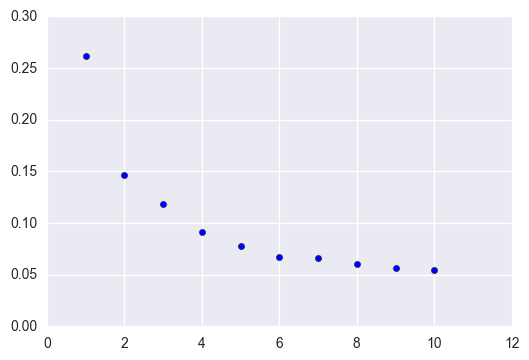

In [109]:
import matplotlib.pyplot as plt
x = [1,2,3,4,5,6,7,8,9,10]
ax = plt.scatter(x,y)
#http://stats.stackexchange.com/questions/22569/pca-and-proportion-of-variance-explained

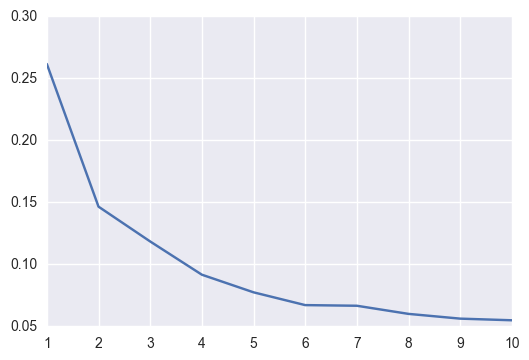

In [110]:
plt.plot(x,y)
#decided to pick 6 PCs

In [111]:
lsa2 = TruncatedSVD(algorithm='randomized', n_components=6)
dtm_lsa2 = lsa2.fit_transform(tfidf_trans)
dtm_lsa3 = Normalizer(copy=False).fit_transform(dtm_lsa2)

In [112]:
pd.DataFrame(lsa2.components_, index = ['com1', 'com2', 'com3', 'com4','com5','com6'], columns=feature_name2).T.head()

,com1,com2,com3,com4,com5,com6
aah,0.002259,-0.000808,0.002464,-0.000077,0.002595,-0.003263
aaron,0.004105,0.003894,-0.005233,-0.007556,-0.002502,-0.000676
aau,0.000706,-0.001708,-0.002240,0.001367,-0.001517,0.004628
abandon,0.005613,-0.000526,0.004078,0.011460,-0.008387,0.002668
abbey,0.001097,-0.001468,0.002697,-0.001701,-0.000848,-0.001677


In [113]:
xs = [w[0] for w in dtm_lsa3]
ys = [w[1] for w in dtm_lsa3]
zs = [w[2] for w in dtm_lsa3]
ws = [w[3] for w in dtm_lsa3]
ts = [w[4] for w in dtm_lsa3]
hs = [w[5] for w in dtm_lsa3]

Populating the interactive namespace from numpy and matplotlib


/Users/KellyKerryChowChow/anaconda2/envs/dsi/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/Users/KellyKerryChowChow/anaconda2/envs/dsi/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


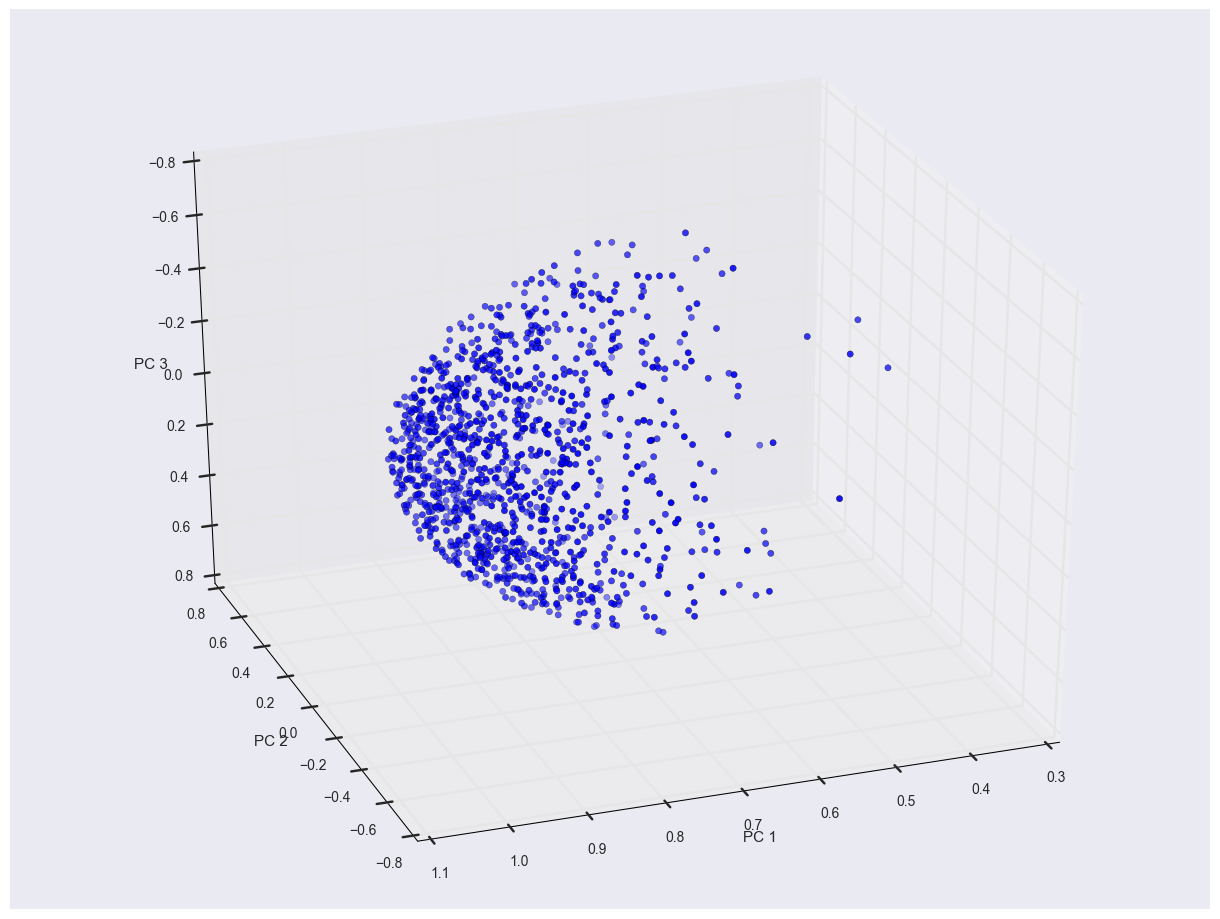

In [114]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline
#t

#statement_y_m = lambda dt: str(dt.year) + '-' + (str(dt.month) if dt.month > 9 else '0' + str(dt.month))

fig = plt.figure(1, figsize=(12, 9))
ax = Axes3D(fig, elev=-150, azim=110)
#p_x = doc_trans_df.PC_1.values
#p_y = doc_trans_df.PC_2.values
#p_z = doc_trans_df.PC_3.values

#ax.scatter(p_x, p_y, p_z,
#            marker='h', s=10)


ax.scatter(xs, ys, zs, zdir='y')

#for i, dt in enumerate(doc_trans_df.index):
#   if not i%6:
#       ax.text(p_x[i],p_y[i],p_z[i], dt.strftime("%Y-%m-%d"), size=10, zorder=1, color='k')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

ax.legend()

# speculation: each dot represents a person/document and the graph shows their similarities. Most of the people
# have similar text on the left cluster. The far away dots on the right don't seem to have much similarity with others

#after removing over 50 customized stopwords, I noticed that the dots are more scattered.

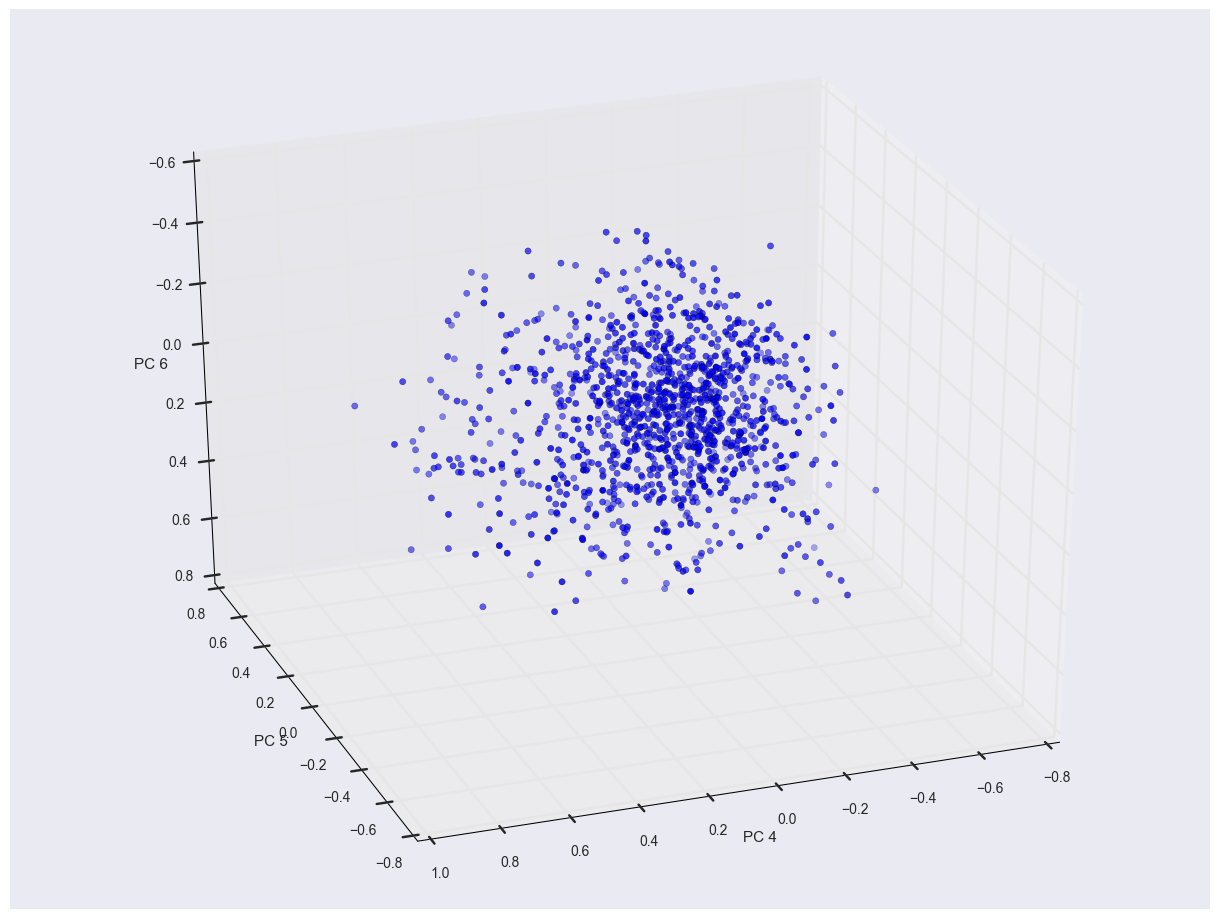

In [115]:


fig = plt.figure(1, figsize=(12, 9))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(ws, ts, hs)


ax.set_xlabel('PC 4')
ax.set_ylabel('PC 5')
ax.set_zlabel('PC 6')

ax.legend()


In [116]:
PC_df = pd.DataFrame(dtm_lsa3).rename(columns = {0:'comp1', 1:'comp2', 2:'comp3', 3:'comp4',4:'comp5',5:'comp6'})

In [117]:
from sklearn.metrics.pairwise import cosine_similarity


In [118]:
similarity = cosine_similarity(np.asmatrix(dtm_lsa3))

In [119]:
lsa_df = pd.DataFrame(similarity, index = groupby_user_msg.user, columns=groupby_user_msg.user)

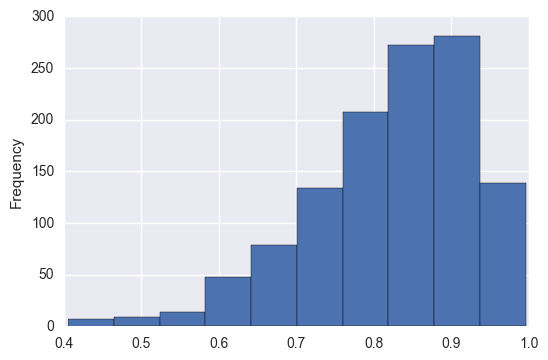

In [127]:
lsa_df['mainuser'].sort_values(ascending=False)[1:].plot(kind='hist')

In [151]:
lsa_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1191 entries, 100000098071661@facebook.com to mainuser
Columns: 1191 entries, 100000098071661@facebook.com to mainuser
dtypes: float64(1191)
memory usage: 10.8+ MB


In [149]:
count_d = { 0:0,
           1:0,
           2:0,
           3:0,
           4:0,
           5:0,
           6:0,
           7:0,
           8:0,
           9:0
    }


In [152]:
for i in range(0,1191):
    #.iloc[150].sort_values(ascending=False)[1:]
    doc = lsa_df.iloc[i]
    for e in range(0,1191):
        element = doc[e]

        if element >= 0.9 and element != 1:
            count_d[9] +=1
        elif element >= 0.8:
            count_d[8] +=1
        elif element >= 0.7:
            count_d[7] +=1
        elif element >= 0.6:
            count_d[6] +=1
        elif element >= 0.5:
            count_d[5] +=1
        elif element >= 0.4:
            count_d[4] +=1
        elif element >= 0.3:
            count_d[3] +=1
        elif element >= 0.2:
            count_d[2] +=1
        elif element >= 0.1:
            count_d[1] +=1

In [139]:
similarity_with_main_user = lsa_df['mainuser'].sort_values(ascending=False)[1:].reset_index()

In [140]:
similarity_with_main_user

,user,mainuser
0,1209390270@facebook.com,0.995739
1,Person_1837,0.992194
2,Person_4053,0.991503
3,Person_903,0.989970
4,Person_2264,0.988694
5,Person_507,0.985784
6,Person_1669,0.985538
7,Person_1945,0.982641
8,Person_743,0.982475
9,Person_783,0.982038


In [157]:
count_dm = { 0:0,
           1:0,
           2:0,
           3:0,
           4:0,
           5:0,
           6:0,
           7:0,
           8:0,
           9:0
    }


In [161]:
similarity_with_main_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 2 columns):
user        1190 non-null object
mainuser    1190 non-null float64
dtypes: float64(1), object(1)
memory usage: 18.7+ KB


In [168]:
for i in range(0,1190):
    #.iloc[150].sort_values(ascending=False)[1:]
    element = similarity_with_main_user.iloc[i][1]
    if element >= 0.9 and element != 1:
        count_dm[9] +=1
    elif element >= 0.8:
        count_dm[8] +=1
    elif element >= 0.7:
        count_dm[7] +=1
    elif element >= 0.6:
        count_dm[6] +=1
    elif element >= 0.5:
        count_dm[5] +=1
    elif element >= 0.4:
        count_dm[4] +=1
    elif element >= 0.3:
        count_dm[3] +=1
    elif element >= 0.2:
        count_dm[2] +=1
    elif element >= 0.1:
        count_dm[1] +=1

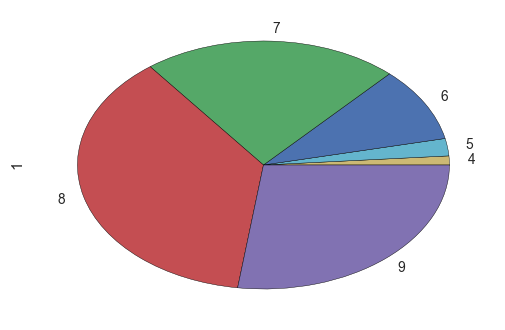

In [173]:
pd.DataFrame(count_dm.items())[1].plot(kind='pie')

In [141]:
friends_list = pd.read_csv("/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/csv/friends_list.csv")

In [143]:
friends_list.drop(['Unnamed: 0'], axis=1, inplace=True)

In [145]:
friends_list.rename(columns={'number':'user'}, inplace=True)

In [147]:
main_user_similar = similarity_with_main_user.merge(friends_list, on='user',how='left')

In [148]:
main_user_similar.to_csv('/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/csv/similar_2mainuser.csv')

## Sk-learn non-negative matrix factorization 
http://www.johnwittenauer.net/language-exploration-using-vector-space-models/

In [227]:
from sklearn.decomposition import NMF  

In [228]:
nmf = NMF(n_components=10).fit(cvec_ft2)

for topic_idx, topic in enumerate(nmf.components_):  
    print('Topic #%d:' % topic_idx)
    print(' '.join([feature_name2[i] for i in topic.argsort()[:-20 - 1:-1]]))
    print('')

    #results from Countvectorizers

Topic #0:
feel talk friend help ask love thought life awesom super share happi tell better learn meet mind enjoy photo kelli

Topic #1:
feel love life hahaha friend ask new relationship ppl care busi tell live gal lolol mind usa understand happi sleep

Topic #2:
effect drug serotonin increas feel dopamin ask better mdma caus brain help differ problem level high learn activ reason dion

Topic #3:
feel love kelli talk bee ask bike mom miss friend help thought learn video share happi togeth tell sleep stay

Topic #4:
joseph feel talk friend help kelli ask yea thought love learn btw better design relationship tell post care life realiz

Topic #5:
feel love life talk ask share date sweet kevin tell relationship learn thought friend emot ryan help creat happen question

Topic #6:
idea meet friend talk help video read post start email app better new pretti question live place project event money

Topic #7:
love awesom meet friend chat help talk super happi amaz yay free plan event david man f

In [242]:
topic_dict = {}
for i in range(1,21):
    topic_dict[i]=[]

In [247]:
topic_dict2 = {}
for i in range(1,31):
    topic_dict2[i]=[]

In [246]:
nmf2 = NMF(n_components=30).fit(tfidf_trans)



for topic_idx, topic in enumerate(nmf2.components_):  
    print('Topic #%d:' % topic_idx)
    print(' '.join([feature_name2[i] for i in topic.argsort()[:-30 - 1:-1]]))
    print('')

    #results from TFiDF
    
    #next: can clean more words like ['kinda','littl','allot','gonna','ttys','gotcha','wanna','btw','omw','ill','ive',
    #'ooh','havent','cuz','tho','cus','didnt','bout','tmr','def','ttyl']
    # basically like topic#28 which is all about special shortened phrases in text
    # should I remove all human names?

Topic #0:
feel relationship talk emot share thought ask convers hard help felt care date guess tell differ better listen read question learn kind friend life understand hurt happi appreci reason togeth

Topic #1:
salon talk discuss stanford sweet monday alexandria topic group chat space question messag garag minerva invit friday bring pretti host kurt thought share organ happen communiti yep appreci book plan

Topic #2:
photo send upload shot post album pictur awesom photographi birthday check sorri photograph link edit smugmug hope parti ceremoni camera len portfolio wonder set com websit instagram jose san quot

Topic #3:
event awesom invit page space tech talk host ticket meetup photograph fun team parti venu communiti organ hack open session hope definit hackathon pleas bay artist anyon project danc attende

Topic #4:
citi communiti build kudavi land tom live capit cultur govern structur economi creat cost develop differ ownership nomad new bali valu start incom place properti impa

In [248]:
for topic_idx, topic in enumerate(nmf2.components_):  
    top_words = (' '.join([feature_name2[i] for i in topic.argsort()[:-20 - 1:-1]]))
    topic_dict2[topic_idx + 1].extend(top_words.split())

In [249]:
topic_dict2

{1: ['feel',
  'relationship',
  'talk',
  'emot',
  'share',
  'thought',
  'ask',
  'convers',
  'hard',
  'help',
  'felt',
  'care',
  'date',
  'guess',
  'tell',
  'differ',
  'better',
  'listen',
  'read',
  'question'],
 2: ['salon',
  'talk',
  'discuss',
  'stanford',
  'sweet',
  'monday',
  'alexandria',
  'topic',
  'group',
  'chat',
  'space',
  'question',
  'messag',
  'garag',
  'minerva',
  'invit',
  'friday',
  'bring',
  'pretti',
  'host'],
 3: ['photo',
  'send',
  'upload',
  'shot',
  'post',
  'album',
  'pictur',
  'awesom',
  'photographi',
  'birthday',
  'check',
  'sorri',
  'photograph',
  'link',
  'edit',
  'smugmug',
  'hope',
  'parti',
  'ceremoni',
  'camera'],
 4: ['event',
  'awesom',
  'invit',
  'page',
  'space',
  'tech',
  'talk',
  'host',
  'ticket',
  'meetup',
  'photograph',
  'fun',
  'team',
  'parti',
  'venu',
  'communiti',
  'organ',
  'hack',
  'open',
  'session'],
 5: ['citi',
  'communiti',
  'build',
  'kudavi',
  'land',
 

In [252]:
f = open('/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/pickle/NMF_30t_20w.p', 'w')
cPickle.dump(topic_dict2, f)
f.close()

In [243]:
for topic_idx, topic in enumerate(nmf2.components_):  
    top_words = (' '.join([feature_name2[i] for i in topic.argsort()[:-20 - 1:-1]]))
    topic_dict[topic_idx + 1].extend(top_words.split())

In [244]:
topic_dict #I am storing 20 topics with 20 topwords
#well, I'm impressed. This is performing way better than LDA

{1: ['feel',
  'relationship',
  'talk',
  'emot',
  'thought',
  'ask',
  'share',
  'convers',
  'friend',
  'tell',
  'question',
  'differ',
  'hard',
  'felt',
  'help',
  'date',
  'care',
  'guess',
  'better',
  'learn'],
 2: ['compani',
  'help',
  'busi',
  'market',
  'client',
  'job',
  'start',
  'develop',
  'project',
  'team',
  'idea',
  'manag',
  'product',
  'meet',
  'connect',
  'social',
  'network',
  'servic',
  'sale',
  'startup'],
 3: ['email',
  'send',
  'post',
  'com',
  'facebook',
  'talk',
  'gmail',
  'contact',
  'messag',
  'sorri',
  'link',
  'sent',
  'write',
  'skype',
  'check',
  'ask',
  'blog',
  'chat',
  'group',
  'phone'],
 4: ['photo',
  'shoot',
  'photographi',
  'photograph',
  'pic',
  'shot',
  'wed',
  'post',
  'ill',
  'cosplay',
  'camera',
  'portfolio',
  'pictur',
  'light',
  'model',
  'send',
  'upload',
  'check',
  'gig',
  'hope'],
 5: ['meet',
  'free',
  'dinner',
  'lunch',
  'plan',
  'sorri',
  'thursday',
  's

In [251]:
f = open('/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/pickle/NMF_20_20.p', 'w')
cPickle.dump(topic_dict, f)
f.close()

In [250]:
nmf3 = NMF(n_components=50).fit(tfidf_trans)



for topic_idx, topic in enumerate(nmf3.components_):  
    print('Topic #%d:' % topic_idx)
    print(' '.join([feature_name2[i] for i in topic.argsort()[:-50 - 1:-1]]))
    print('')

    #50 topics with 50 keywords
    # it is able to extract the most common domain-specific topics like bitcoin, photos, community, salon
    #effective altruism, less wrong, chatbot, kickstarter, ideo/design, relationship, philosophy, bro talk, 
    #girlfriend, startups, draper, party/adventure, psychelelics, theil, social media, diet, ephemerisle/burning man,
    # ideaflow, lifelog, traveling, transportation, taiwan, life problems, hackathon, school, sick

Topic #0:
feel talk thought share emot hard felt convers read guess sleep appreci tell better wonder listen littl kind care learn happen differ messag comfort rememb face notic hurt experi self vulner realiz bad alway curious hope enjoy stop told sometim help interact hear plan express home mention abl wow expect

Topic #1:
meet free dinner lunch sorri plan thursday place late check saturday friday sunday schedul park sometim home coffe afternoon morn catch tuesday stay unfortun head open food abl stanford min join monday attend train forward drive tea wednesday ish hope campus citi new talk weekend area prepar downtown wait anoth

Topic #2:
compani market job develop startup busi hire start social manag team sale data product investor engin fund tech custom softwar stage contract founder intern technolog servic meet focus current earli network plan search corpor area creat anyon new advic smart grow talent onlin deal project entrepreneur googl revenu strategi potenti

Topic #3:
shoot 

In [253]:
topic_dict3 = {}
for i in range(1,51):
    topic_dict3[i]=[]

for topic_idx, topic in enumerate(nmf3.components_):  
    top_words = (' '.join([feature_name2[i] for i in topic.argsort()[:-50 - 1:-1]]))
    topic_dict3[topic_idx + 1].extend(top_words.split())

In [254]:
f = open('/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/pickle/NMF_50t_50w.p', 'w')
cPickle.dump(topic_dict3, f)
f.close()

In [262]:
NMF_50_50_df = pd.DataFrame(topic_dict3)

In [263]:
NMF_50_50_df.to_csv('/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/csv/NMF_50t_50w_df.csv')

In [256]:
topic_dict4 = {}
for i in range(1,51):
    topic_dict4[i]=[]

for topic_idx, topic in enumerate(nmf3.components_):  
    top_words = (' '.join([feature_name2[i] for i in topic.argsort()[:-100 - 1:-1]]))
    topic_dict4[topic_idx + 1].extend(top_words.split())
    
#50 topics, 100 words

In [266]:
NMF_50t_100w_df = pd.DataFrame(topic_dict4).T

In [267]:
NMF_50t_100w_df.head(1)
#first topic

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1,feel,talk,thought,share,emot,hard,felt,convers,read,guess,...,natur,hang,mind,yesterday,sweet,warm,safe,difficult,whatev,cri


## The code below is following this tutorial:
https://de.dariah.eu/tatom/topic_model_python.html


In [741]:
# https://de.dariah.eu/tatom/topic_model_python.html
clf = NMF(n_components=50, alpha=.1, l1_ratio=0, random_state=1) #not sure what random_state does
doctopic = clf.fit_transform(tfidf_trans)

In [742]:
topic_words = []
num_top_words = 100
vocab = feature_name2
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])

In [743]:
doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)
#To make the analysis and visualization of NMF components similar to that of LDA’s topic proportions, 
#we will scale the document-component matrix such that the component values associated with each document sum to one.

In [748]:
user_names = list(processed_df.user)

In [749]:
doctopic_orig = doctopic.copy()


In [751]:
user_names = np.asarray(user_names)
num_groups = len(set(user_names))
num_topics = 50
doctopic_grouped = np.zeros((num_groups, num_topics))


for i, name in enumerate(sorted(set(user_names))):
    doctopic_grouped[i, :] = np.mean(doctopic[user_names == name, :], axis=0)

doctopic = doctopic_grouped

In [761]:
doc_2_topic_df = pd.DataFrame(doctopic_grouped)

In [762]:
f = open('/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/pickle/NMF_50t_100w_df_12_4.p', 'w')
cPickle.dump(doc_2_topic_df, f)
f.close()

In [768]:
doc_2_topic_df.columns = labeled_topics.values()
#map(lambda x: "Topic_" + str(x), range(1,51))

In [776]:
doc_2_topic_df['user_name'] = processed_df.user

In [784]:
doc_2_topic_df.tail(2)

,self-care / emotional connection,gethering/ casual meeting,business/ startup,photography,rationality community,videography/ crowd-sourcing campaign/ lifelogging,intentional community/ building a city,party,crypto-currency/ investment,design-thinking/ creativity,...,unknown4,community,music/ art,chatbot,mental models,game,romantic relationship,school/ education,writing/ knowledge sharing,user_name
1189,0.074483,0.000000,0.000000,0.011285,0.000000,0.137536,0.000000,0.006530,0.0,0.00257,...,0.001352,0.025538,0.028665,0.000000,0.0225,0.020423,0.00000,0.00000,0.128357,Person_997
1190,0.102203,0.014859,0.004932,0.039313,0.006821,0.041119,0.004172,0.017171,0.0,0.00000,...,0.030005,0.013807,0.012709,0.014129,0.0279,0.021522,0.00785,0.00983,0.024753,mainuser


In [843]:
f = open('/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/csv/NMF_50t_100w_df_12_6.p', 'w')
cPickle.dump(doc_2_topic_df, f)
f.close()

In [841]:
params = {'axes.labelsize': 'x-large',
         'font.size': 22,
         'axes.labelsize': 'large',
         'axes.titlesize': 'large',
         'ytick.labelsize': 'large',
         'xtick.labelsize': 'large'}
plt.rcParams.update(params)

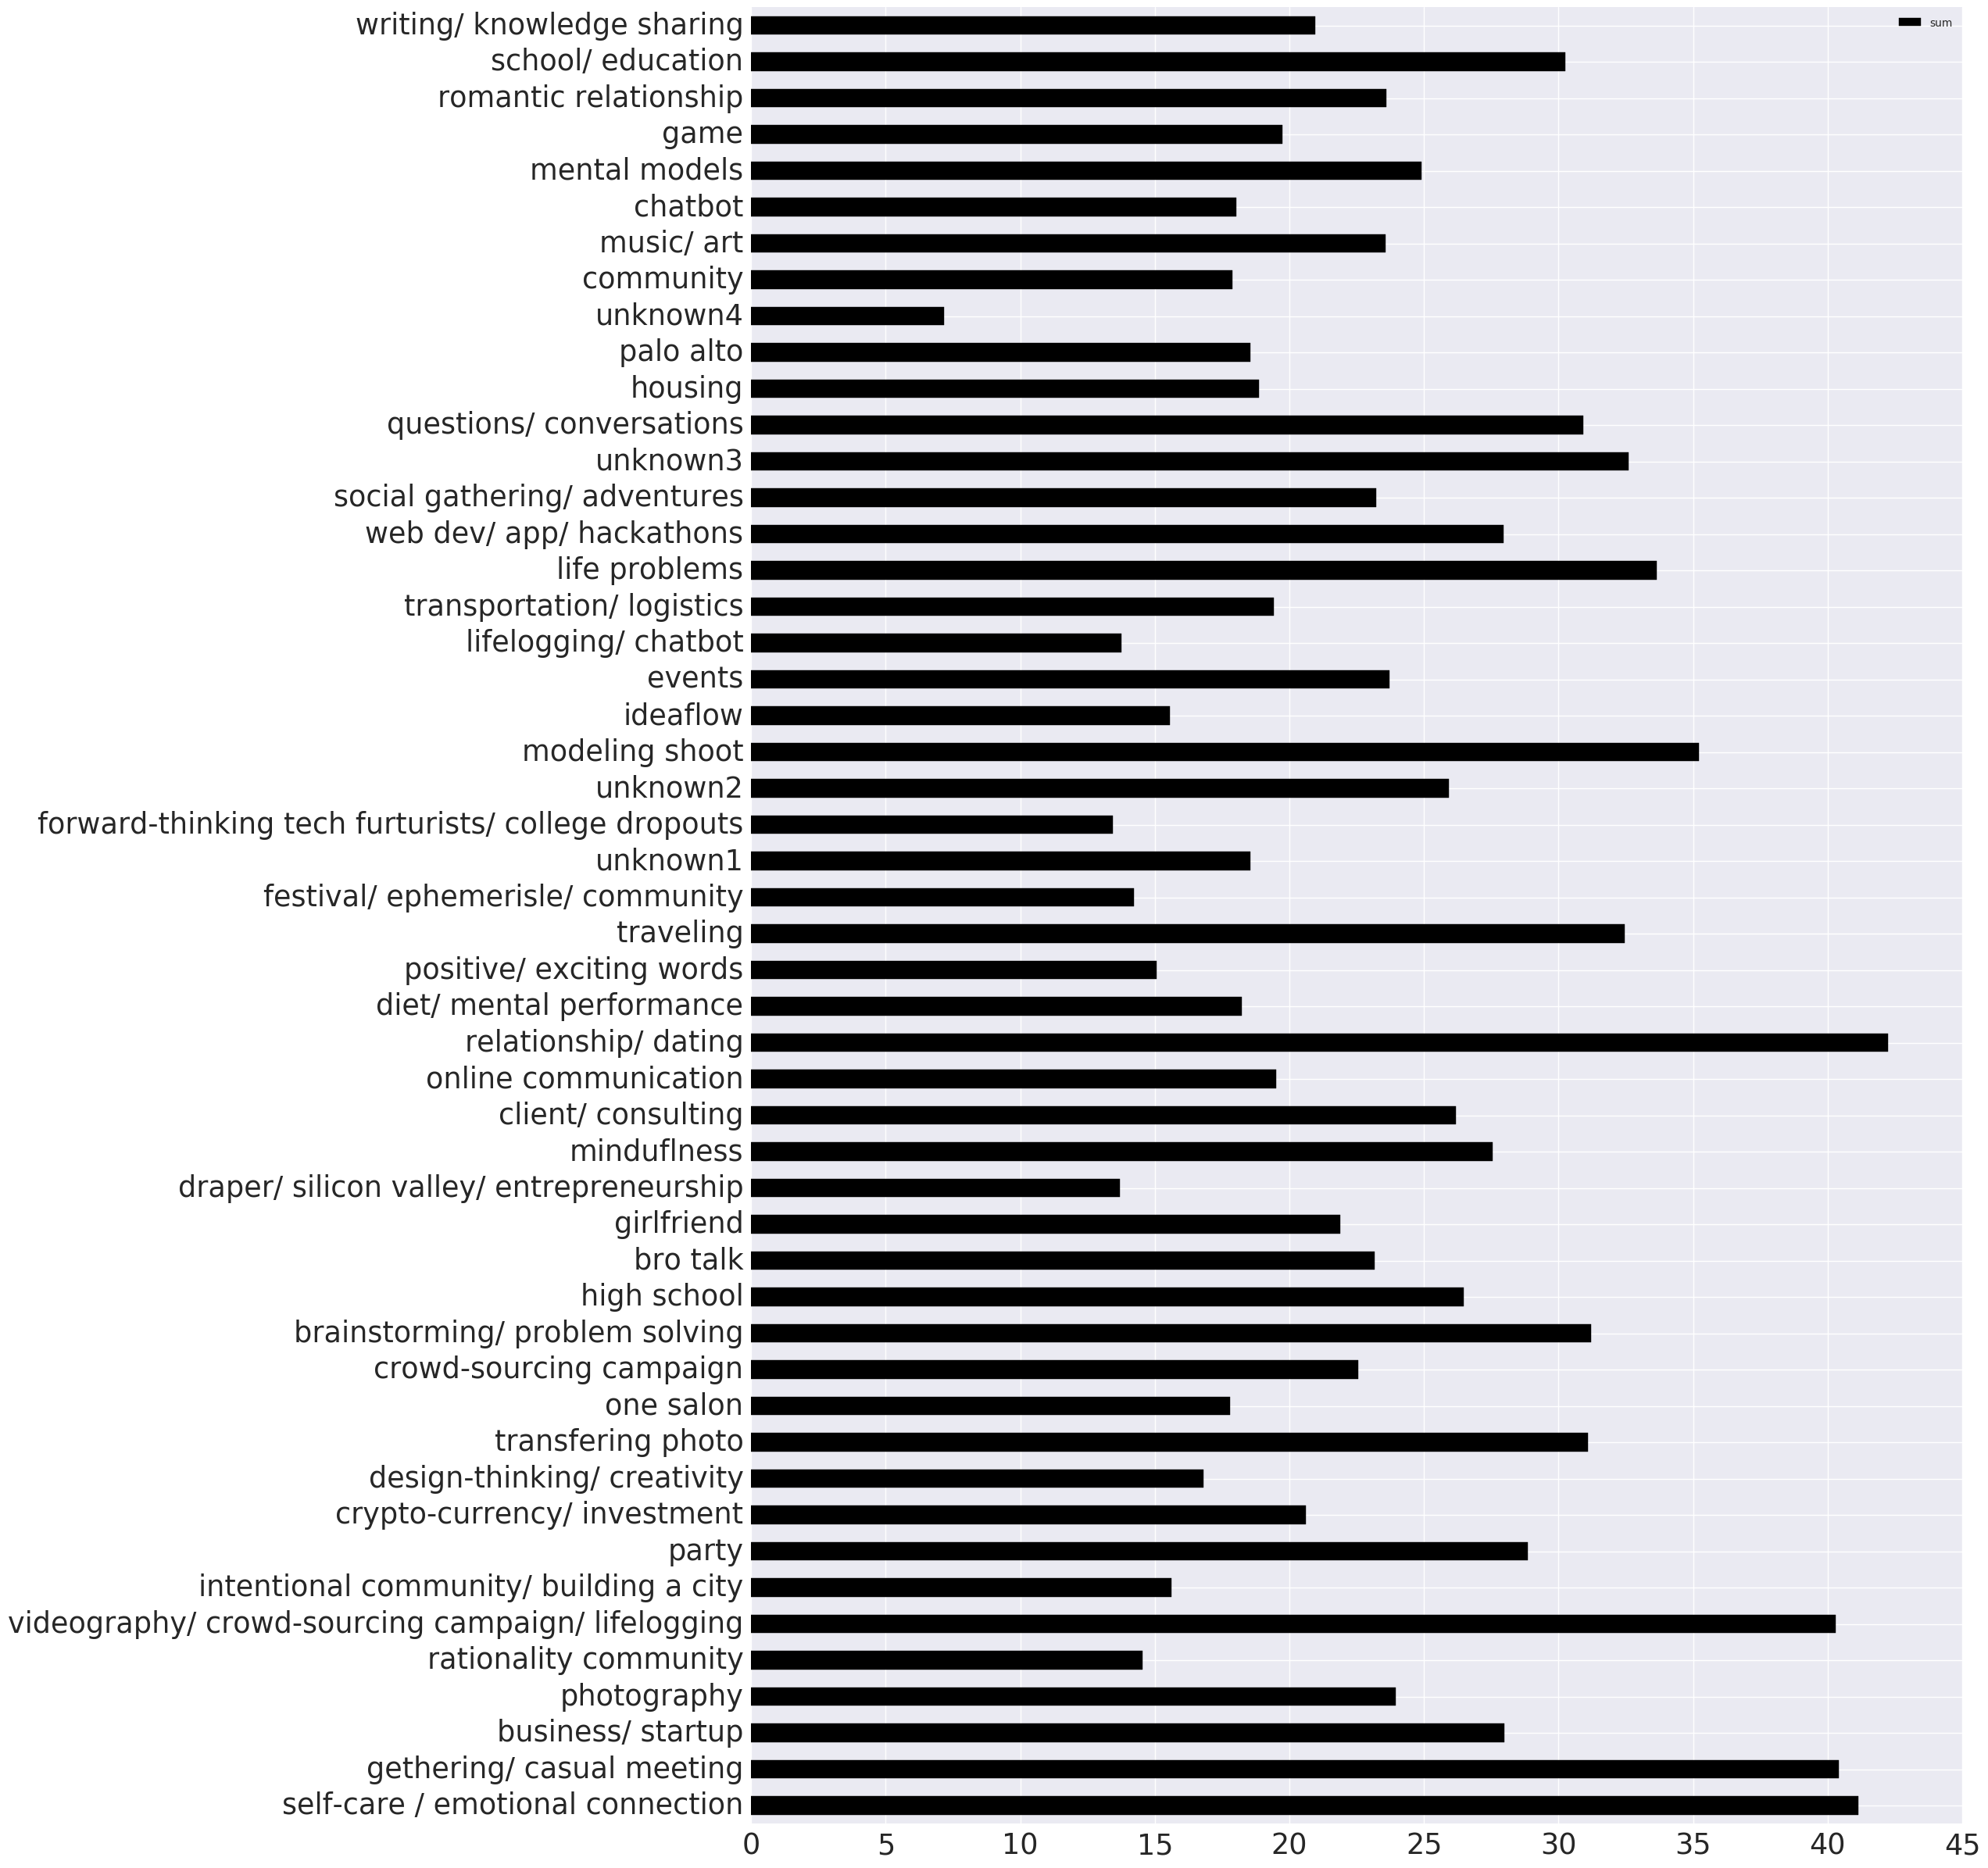

In [842]:
#http://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
fig, ax = plt.subplots(1,1,figsize=(20,30))

topic_sum = pd.DataFrame(doc_2_topic_df.sum()).iloc[:-1,:]
topic_sum.plot(kind='barh', color='k', ax=ax)

legend(['sum'])

In [766]:
labeled_topics = {1: 'self-care / emotional connection',
2: 'gethering/ casual meeting',
3: 'business/ startup',
4: 'photography',
5: 'rationality community',
6: 'videography/ crowd-sourcing campaign/ lifelogging',
7: 'intentional community/ building a city',
8: 'party',
9: 'crypto-currency/ investment',
10: 'design-thinking/ creativity',
11: 'transfering photo',
12: 'one salon',
13: 'crowd-sourcing campaign',
14: 'brainstorming/ problem solving',
15: 'high school',
16: 'bro talk',
17: 'girlfriend',
18: 'draper/ silicon valley/ entrepreneurship',
19: 'minduflness',
20: 'client/ consulting',
21: 'online communication',
22: 'relationship/ dating',
23: 'diet/ mental performance',
24: 'positive/ exciting words',
25: 'traveling',
26: 'festival/ ephemerisle/ community',
27: 'unknown1',
28: 'forward-thinking tech furturists/ college dropouts',
29: 'unknown2',
30: 'modeling shoot',
31: 'ideaflow',
32: 'events',
33: 'lifelogging/ chatbot',
34: 'transportation/ logistics',
35: 'life problems',
36: 'web dev/ app/ hackathons',
37: 'social gathering/ adventures',
38: 'unknown3',
39: 'questions/ conversations',
40: 'housing',
41: 'palo alto', 
42: 'unknown4',
43: 'community',
44: 'music/ art',
45: 'chatbot',
46: 'mental models',
47: 'game',
48: 'romantic relationship',
49: 'school/ education',
50: 'writing/ knowledge sharing'}

In [726]:
nmf4 = NMF(n_components=20, alpha=0.3,l1_ratio=0 ).fit(tfidf_trans)
# elementwise L2 penalty (aka Frobenius Norm) if l1_ratio=0
# combination of L1 and L2 if l1_ratio is between 0 and 1



for topic_idx, topic in enumerate(nmf4.components_):  
    print('Topic #%d:' % topic_idx)
    print(' '.join([feature_name2[i] for i in topic.argsort()[::-1][:20]]))
    print('')
    
#trying regularization and it sems to be a little bit better but not significant

Topic #0:
feel talk thought emot ask tell hard guess sleep share felt better convers read kind happen mind help littl care

Topic #1:
meet free dinner sorri lunch plan thursday sunday late friday friend awesom place check schedul sometim saturday talk catch park

Topic #2:
compani help busi market client job team project manag ask start idea develop servic social product network connect sale startup

Topic #3:
video kickstart edit talk footag replay film camera awesom music record project campaign com http clip free gopro file shoot

Topic #4:
love kelli awesom amaz share connect hear happi help life feel excit wow learn salon hope pleas experi chat hahaha

Topic #5:
event invit parti friend space salon group talk embassi fun awesom host page sunday plan weekend communiti adventur meetup com

Topic #6:
bitcoin coin btc buy currenc money card sell invest price game ltc trade valu gox mtgox litecoin crypto basic miner

Topic #7:
school friend hahaha life live famili parent kid food mom a

In [728]:
nmf5 = NMF(n_components=20, alpha=0.1,l1_ratio=0, random_state=1 ).fit(tfidf_trans)
# elementwise L2 penalty (aka Frobenius Norm) if l1_ratio=0
# combination of L1 and L2 if l1_ratio is between 0 and 1



for topic_idx, topic in enumerate(nmf5.components_):  
    print('Topic #%d:' % topic_idx)
    print(' '.join([feature_name2[i] for i in topic.argsort()[::-1][:20]]))
    print('')
    
#trying regularization and it seems to be a little bit better but not huge

Topic #0:
feel relationship talk emot thought share ask convers friend help life care hard tell question date guess better differ read

Topic #1:
meet free dinner lunch sorri plan thursday talk late sunday friday check schedul sometim place saturday friend stanford afternoon monday

Topic #2:
app design project idea email compani product develop build android start team send help com web job softwar code devic

Topic #3:
citi communiti build kudavi land tom live capit govern cultur hous develop structur creat start new cost economi space place

Topic #4:
photo shoot photographi photograph shot pic post send pictur wed upload portfolio check model hope light camera gig sorri email

Topic #5:
draper startup program help busi fund compani scholarship market tim student ask team connect entrepreneur valley post network entrepreneurship pitch

Topic #6:
kelli ask question tell love start salon health jacob mike stanford parent bring bike help kelly hous taiwan happi taiwanes

Topic #7:
love

In [729]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [731]:
from sklearn.decomposition import LatentDirichletAllocation

In [736]:
from time import time

In [737]:
n_topics = 20

print("Fitting LDA models with tf features")
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tfidf_trans)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")

print_top_words(lda, feature_name2, 20)

# LDA generates a lot more non-sense topics than NMF

# http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html

Fitting LDA models with tf features
done in 2.522s.

Topics in LDA model:
Topic #0:
ask kelli talk tell convers minerva feel skype question context cultur natur meet hallo weight import book retir preso step
Topic #1:
love meet talk friend feel help event idea awesom start ask thought plan sorri life hope learn video free new
Topic #2:
transcript beleiv bride yup read car pseudo everyon ozzi signal menlo buffalo freemium factor macro cfar fist intellectu damien sleev
Topic #3:
savag mma group amass famili bernal gov alex alma nap man vista future holi melt mac envis palo masquerad lmao
Topic #4:
robot histori data lens love idea communiti squar chapel grace special given misha transit comment wife mealsquar help pixar comput
Topic #5:
love meet feel overflow friend project hope food experi sorri order hous bring awesom malcom wanna jacob min new bay
Topic #6:
ambassador direct pool jesus unlearn spam dilig muir winner pdt horn blogspot pro gate unsatisfi uncommon cheaper silo def drawb

In [738]:
nmf6 = NMF(n_components=20, alpha=0.2,l1_ratio=1, random_state=1 ).fit(tfidf_trans)
# elementwise L2 penalty (aka Frobenius Norm) if l1_ratio=0
# combination of L1 and L2 if l1_ratio is between 0 and 1

                            
t0 = time()

print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
print_top_words(nmf6, feature_name2, 20)

#Seems like when I set a strong regularization, the result gets worse with 'zuckerberg' keeps showing up


done in 0.000s.

Topics in NMF model:
Topic #0:
love feel meet talk friend help awesom idea event start ask thought plan life learn video free better hope new
Topic #1:
zuckerberg forefront ford forc forbidden forb forag footprint foothil footbal footag foot foolish fool food foo font forecast foreground frighten
Topic #2:
zuckerberg forefront ford forc forbidden forb forag footprint foothil footbal footag foot foolish fool food foo font forecast foreground frighten
Topic #3:
zuckerberg forefront ford forc forbidden forb forag footprint foothil footbal footag foot foolish fool food foo font forecast foreground frighten
Topic #4:
zuckerberg forefront ford forc forbidden forb forag footprint foothil footbal footag foot foolish fool food foo font forecast foreground frighten
Topic #5:
draper talk email parti program phone school weekend dinner hehe yoga scienc yep topic palo alto busi skype messag summer
Topic #6:
kelli app tell man project pretti dude sleep hous applic sorri ask music aw

#### Note: using Tfidf gives more unique topics
the problem with NMF is that it does not provide the weight of each term in each topic

In [273]:
# input: each document represented by a list of words in unicode
# and 50 topics represented by a list of 100 words

In [346]:
feature_name2[1268]

'cfar'

In [297]:
nmf3.components_[0].argsort()[-10 -1:-1]
#returns a list of index# that will be matched to a word. One topic.

array([7577, 3596, 6698, 1738, 3005, 3711, 2643, 7395, 8399, 8216])

In [316]:
np.sort(nmf3.components_[0])[-10 -1:-1]
#returns a list of weights for each word in one topic

array([ 0.21647057,  0.22953972,  0.23319919,  0.25145705,  0.26583364,
        0.27016875,  0.28427284,  0.29677111,  0.38357842,  0.59661106])

In [333]:
np.sort(nmf3.components_[0])[::-1]

array([ 1.74031618,  0.59661106,  0.38357842, ...,  0.        ,
        0.        ,  0.        ])

In [351]:
nmf3.components_[4].argsort()[-10 -1:]

array([2749, 8216, 7881, 5291, 6683, 6681,  699, 5152, 9331,  767, 1268])

In [352]:
nmf3.components_[4].argsort()[::-1][:10]
#descending order then pick the top 10

array([1268,  767, 9331, 5152,  699, 6681, 6683, 5291, 7881, 8216])

In [355]:
np.sort(nmf3.components_[4])[::-1][:10]

array([ 1.22220223,  0.68875842,  0.53902759,  0.50654055,  0.46975956,
        0.40699319,  0.39105712,  0.33860489,  0.30982231,  0.30479889])

In [356]:
zip(nmf3.components_[4].argsort()[::-1][:10], np.sort(nmf3.components_[4])[::-1][:10])

[(1268, 1.2222022331564599),
 (767, 0.68875842343074167),
 (9331, 0.53902759301889713),
 (5152, 0.50654054896849399),
 (699, 0.46975956024236554),
 (6681, 0.40699318704508425),
 (6683, 0.3910571175537283),
 (5291, 0.33860489052806059),
 (7881, 0.30982231354254075),
 (8216, 0.30479889143935102)]

In [357]:
topic_dict5 = {}
for i in range(1,51):
    topic_dict5[i]=[]

for topic_idx, topic in enumerate(nmf3.components_):  
    top_words = [feature_name2[i] for i in topic.argsort()[::-1][:100]]
    top_weights = np.sort(topic)[::-1][:100]
    topic_tupe = zip(top_words, top_weights)
    topic_dict5[topic_idx + 1].extend(topic_tupe)
    
#50 topics, 100 words

In [367]:
f = open('/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/pickle/NMF_50t_100w_weight.p', 'w')
cPickle.dump(topic_dict5, f)
f.close()

In [470]:
topic_dict5 = {}
for i in range(1,51):
    topic_dict5[i]=[]

for topic_idx, topic in enumerate(nmf3.components_):  
    top_words = [feature_name2[i] for i in topic.argsort()[::-1][:100]]
    top_weights = np.sort(topic)[::-1][:100]
    top_weights_percent = map(lambda x: 100*x/sum(top_weights), top_weights)
    topic_tupe = zip(top_words, top_weights_percent)
    topic_dict5[topic_idx + 1].extend(topic_tupe)
    
#50 topics, 100 words

# normalizing the weights byt getting percentage

In [471]:
topic_dict5[5]

[('cfar', 7.4133585001337465),
 ('berkeley', 4.1777154175968203),
 ('workshop', 3.2695119351837474),
 ('meetup', 3.0724593545046179),
 ('bay', 2.8493615331956441),
 ('ration', 2.4686474306997561),
 ('rationalist', 2.37198601655935),
 ('miri', 2.0538331343907075),
 ('start', 1.8792502740728259),
 ('talk', 1.8487803338794879),
 ('eric', 1.8423834236633965),
 ('area', 1.8222917840632937),
 ('skill', 1.6888181663759478),
 ('vancouv', 1.4601708349980402),
 ('lesswrong', 1.4219473388018162),
 ('group', 1.4131696253463726),
 ('south', 1.3512298881101026),
 ('minut', 1.1735191492065762),
 ('plan', 1.1121733553359536),
 ('pretti', 1.105513096875959),
 ('free', 1.0667560352257979),
 ('chat', 1.0115771255196284),
 ('job', 0.99421478023991083),
 ('skype', 0.9633983559991669),
 ('anna', 0.88394839341139575),
 ('danc', 0.84822222732879649),
 ('tell', 0.83239955193715109),
 ('possibl', 0.8210536299796467),
 ('post', 0.80297211502169463),
 ('involv', 0.79988844733101583),
 ('recommend', 0.797601628733

In [463]:
1.14/sum([0.1,0.2,0.3,0.4,0.5,0.6,0.7])

0.40714285714285714

## Counting document words and Categorize into the 50 topics

#### 1. First remove the words that are not in any of the 50 topic list

In [370]:

words_in_topic50 = []

for topic in nmf3.components_:  
    top_words = [feature_name2[i] for i in topic.argsort()[::-1][:100]]
    for word in top_words:
        if word in words_in_topic50:
            continue
        else:
            words_in_topic50.append(word)



In [372]:
len(words_in_topic50)
#in the 50 topics of 100 words (5000 words in total), 2085 of them are unique

2085

In [377]:
def remove_words(L): #input: a list
    return filter(lambda x: x if x in words_in_topic50 else '', L)

In [379]:
remove_words(['think','cfar','dog','quai','im','video'])

['cfar', 'video']

In [381]:
captured_w = processed_df.message.map(remove_words)

#### 2. Second count the number of times a set of words appear in each topic

In [384]:
captured_w[0]

[u'share',
 u'watch',
 u'respond',
 u'max',
 u'wow',
 u'awesom',
 u'sorri',
 u'sunday',
 u'bus',
 u'sick',
 u'meet',
 u'event',
 u'natur',
 u'opportun',
 u'ice',
 u'break',
 u'share',
 u'context',
 u'environ',
 u'meet',
 u'man',
 u'help',
 u'climb',
 u'huh',
 u'set',
 u'experi',
 u'challeng',
 u'stori',
 u'pretti',
 u'close',
 u'real',
 u'start',
 u'convers',
 u'stranger',
 u'ago',
 u'help',
 u'introduc',
 u'start',
 u'point',
 u'closer',
 u'possibl',
 u'small',
 u'plus',
 u'introduc',
 u'format',
 u'onlin',
 u'provid',
 u'introduct',
 u'happen',
 u'introduct',
 u'experi',
 u'messeng',
 u'felt',
 u'natur',
 u'miss',
 u'benefit',
 u'face',
 u'face',
 u'social',
 u'feedback',
 u'real',
 u'tim',
 u'engag',
 u'especi',
 u'meet',
 u'anoth',
 u'exampl',
 u'roast',
 u'bonfir',
 u'beach',
 u'friend',
 u'ask',
 u'invit',
 u'brother',
 u'end',
 u'becom',
 u'friend',
 u'group',
 u'exampl',
 u'invit',
 u'close',
 u'friend',
 u'eat',
 u'busi',
 u'hous',
 u'dinner',
 u'spend',
 u'meal',
 u'talk',
 u

In [472]:
next(topic_dict5.iteritems())[1][0]
#topic one, look at words, take the first word

('feel', 11.310257757020105)

In [396]:
from collections import Counter
doc0count = Counter(processed_df.message[0])
#turn document zero into a dictionary of word counts

In [422]:
next(doc0count.iteritems())

(u'summer', 1)

In [406]:
next(doc0count.iterkeys())

u'summer'

In [420]:
test_d = {}
for i in range(1,51):
    test_d[i]=[]

In [421]:
test_d[1]

[]

In [431]:
"-->".join(processed_df.message[0])

u'frand-->share-->watch-->respond-->max-->least-->wow-->awesom-->sorri-->sunday-->kamakshi-->bus-->top-->porch-->sick-->meet-->event-->natur-->opportun-->ice-->break-->virtu-->share-->context-->environ-->meet-->man-->help-->tall-->climb-->rout-->huh-->rout-->set-->experi-->perenni-->challeng-->stori-->behind-->pretti-->close-->real-->start-->convers-->stranger-->two-->ago-->often-->help-->pre-->introduc-->interest-->start-->point-->may-->closer-->possibl-->small-->plus-->introduc-->format-->onlin-->simultan-->gavin-->provid-->smooth-->introduct-->happen-->recal-->introduct-->experi-->via-->messeng-->felt-->natur-->miss-->without-->benefit-->face-->face-->social-->feedback-->real-->tim-->engag-->etc-->especi-->critic-->meet-->anoth-->exampl-->roast-->sausag-->bonfir-->beach-->friend-->ask-->invit-->brother-->schuyler-->end-->along-->becom-->friend-->group-->exampl-->invit-->close-->friend-->eat-->part-->busi-->hous-->dinner-->spend-->meal-->talk-->allow-->natur-->connect-->form-->guest-

In [473]:
#see how document one was distributed by topic
#first count the words, second assign weight * counts
doc0_dict = {}
doc0 = processed_df.message[0] # list of words

for topic_ind, list_word_tupe in topic_dict5.iteritems(): # a tuple of (topic_id, [(word,weight),(word2, weight2)])
    doc0_dict[topic_ind] = [word for word, weight in list_word_tupe if word in doc0 ]
    

In [474]:
next(doc0_dict.iteritems())

(1,
 ['talk',
  'share',
  'felt',
  'convers',
  'happen',
  'face',
  'experi',
  'self',
  'help',
  'home',
  'wow',
  'spend',
  'late',
  'point',
  'miss',
  'came',
  'minut',
  'natur'])

In [475]:
for topic_ind,list_w in doc0_dict.iteritems():
    doc0_dict[topic_ind] = Counter(list_w)

In [481]:
doc0_dict[1].items()

[('point', 1),
 ('convers', 1),
 ('spend', 1),
 ('natur', 1),
 ('self', 1),
 ('felt', 1),
 ('share', 1),
 ('minut', 1),
 ('face', 1),
 ('late', 1),
 ('came', 1),
 ('home', 1),
 ('happen', 1),
 ('experi', 1),
 ('miss', 1),
 ('wow', 1),
 ('talk', 1),
 ('help', 1)]

In [495]:
new_doc0_dict={}
for topic_ind, list_w in topic_dict5.iteritems():
    list2 = doc0_dict[topic_ind].items()
    list1 = list_w
    elems = set(chain.from_iterable(list2))
    matched_weight = [tup for tup in list1 if elems.intersection(tup)]
    word_count = doc0_dict[topic_ind]
    word_weight = dict(matched_weight)
    new_doc0_dict[topic_ind] = dict([ (k,v * word_weight[k]) for k,v in word_count.iteritems()])

In [514]:
L = []
for i in range(1,51):
    L.append(sum(new_doc0_dict[i].values()))

In [516]:
sort_L = sort(L)
sort_L

array([  1.04790415,   2.21323583,   4.65427357,   4.77337609,
         5.45969637,   5.58125684,   6.07868072,   6.29601062,
         6.48497947,   6.48708674,   7.02157245,   7.08958346,
         7.8180294 ,   8.02824382,   8.09171962,   8.21848378,
         8.25313199,   8.81531999,   9.02322058,   9.18734968,
         9.74684692,   9.91280742,   9.98498315,   9.99776023,
        10.52950427,  10.67386133,  10.89966674,  10.90673969,
        11.23702397,  12.29956968,  13.43827838,  14.3191461 ,
        14.33848979,  14.44448142,  14.65593292,  15.09210653,
        15.23131067,  18.18977041,  18.6811186 ,  19.04128094,
        19.92931369,  20.902156  ,  24.80270767,  25.18871206,
        26.31315518,  28.09193253,  28.68126841,  30.99855178,
        32.24537015,  35.32224342])

In [522]:
array(L).argsort()
#in ascending order

array([43,  3,  6, 27,  8, 16, 14, 45, 30, 44, 25,  7, 13, 29, 48, 37, 46,
       35, 22, 41, 24, 32, 28, 40, 10,  9,  5, 19, 18,  2, 20, 33, 47, 26,
       17, 34, 49, 11,  4, 42,  0, 23, 36, 39, 12, 38, 15, 31,  1, 21])

In [524]:
sorted_topic= zip(array(L).argsort(),sort(L))
sorted_topic[::-1]

[(21, 35.322243417132135),
 (1, 32.245370149984815),
 (31, 30.998551783948983),
 (15, 28.681268411540323),
 (38, 28.091932531240971),
 (12, 26.313155177578313),
 (39, 25.188712063702162),
 (36, 24.802707665994149),
 (23, 20.902156000805647),
 (0, 19.929313686840956),
 (42, 19.041280935819671),
 (4, 18.681118602135189),
 (11, 18.18977041284473),
 (49, 15.231310667622777),
 (34, 15.09210652666656),
 (17, 14.655932924443153),
 (26, 14.44448141827959),
 (47, 14.338489788829435),
 (33, 14.319146098691188),
 (20, 13.438278383717149),
 (2, 12.299569676410396),
 (18, 11.237023969049366),
 (19, 10.906739689587885),
 (5, 10.899666741913112),
 (9, 10.673861333193516),
 (10, 10.529504265677076),
 (40, 9.9977602348403316),
 (28, 9.9849831469407118),
 (32, 9.9128074163684232),
 (24, 9.7468469222160898),
 (41, 9.1873496772860879),
 (22, 9.0232205769609752),
 (35, 8.8153199917996599),
 (46, 8.253131985587288),
 (37, 8.218483784687951),
 (48, 8.0917196234391646),
 (29, 8.0282438151130844),
 (13, 7.8180

In [477]:
from itertools import chain

list1 = [('We', 'all'), ('all', 'live'), ('live', 'in'), ('in', 'a'),('a', 'yellow'), ('yellow', 'submarine.')]
list2 = [('A', 'live'), ('live', 'yellow'), ('yellow', 'submarine'),('submarine', 'lifeform'), ('lifeform', 'in'), ('in', 'a'),('a', 'sea.')]

elems = set(chain.from_iterable(list2))

[tup for tup in list1 if elems.issuperset(tup)]
#[('live', 'in'), ('in', 'a'), ('a', 'yellow')]

#http://stackoverflow.com/questions/15107541/in-python-picking-tuples-from-two-list-of-tuples-if-both-the-list-contain-common

[('live', 'in'), ('in', 'a'), ('a', 'yellow')]

### Apply to the rest of the 1200 documents

In [531]:
def find_topics(msg): #input: a list of words

    doc_dict = {}
    #new_doc_dict={}
    for topic_ind, list_word_tupe in topic_dict5.iteritems(): # a tuple of (topic_id, [(word,weight),(word2, weight2)])
        doc_dict[topic_ind] = Counter([word for word, weight in list_word_tupe if word in msg])
        
        # a topic dictionary with a list of possibly duplicated words for each topic
        #returns a dictionary with words and count
        #list2 = doc_dict[topic_ind].items() #turn dictionary of word counts to a list of tuples
        #list1 = list_word_tupe
        #elems = set(chain.from_iterable(list2))
        #matched_weight = [tup for tup in list1 if elems.intersection(tup)] 
        # find matching words from pre-built topics dict and from topic dic from each document
        
        word_count = doc_dict[topic_ind]
        
        #word_weight = dict(matched_weight)
        #doc_dict[topic_ind] = dict([ (k,v * word_weight[k]) for k,v in word_count.iteritems()])
        
        word_weight = dict(list_word_tupe)
        doc_dict[topic_ind] = dict([ (k,v * word_weight[k]) for k,v in word_count.iteritems()])

    return doc_dict
        


In [535]:
find_topics(captured_w[0])

{1: {'came': 0.60944805422231318,
  'convers': 1.6342110976745694,
  'experi': 0.96841416902715194,
  'face': 1.0098633223007463,
  'felt': 1.7276441265965572,
  'happen': 1.0890172384415993,
  'help': 0.80574370661893868,
  'home': 0.77360668209657912,
  'late': 0.65407508822454252,
  'minut': 0.56626717318078679,
  'miss': 0.63857082903624618,
  'natur': 0.5603635692760901,
  'point': 0.64094360043330945,
  'self': 0.95560165453381396,
  'share': 1.9287057000529428,
  'spend': 0.72559645494953984,
  'talk': 3.8773557249513111,
  'wow': 0.76388549522391935},
 2: {'anoth': 0.69306709988473614,
  'busi': 0.54814150668667905,
  'dinner': 2.7944021301095163,
  'earli': 0.69251238966163153,
  'free': 3.1906544768080245,
  'fun': 0.63110982699313234,
  'home': 1.3944353514824526,
  'intro': 0.6756013455740445,
  'late': 1.7544894154405879,
  'meet': 12.514597611953882,
  'park': 1.4331894086648334,
  'pretti': 0.59142790771500531,
  'sorri': 2.1732378452254522,
  'start': 0.4473681240062016

In [537]:
captured_dict = map(find_topics, captured_w)

In [548]:
f = open('/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/pickle/msg_topic_dict.p', 'w')
cPickle.dump(captured_dict, f)
f.close()

In [544]:
#sort based of values of dict. Find the words with largest values
import operator

In [552]:
captured_dict[:2]

[{1: {'came': 0.60944805422231318,
   'convers': 1.6342110976745694,
   'experi': 0.96841416902715194,
   'face': 1.0098633223007463,
   'felt': 1.7276441265965572,
   'happen': 1.0890172384415993,
   'help': 0.80574370661893868,
   'home': 0.77360668209657912,
   'late': 0.65407508822454252,
   'minut': 0.56626717318078679,
   'miss': 0.63857082903624618,
   'natur': 0.5603635692760901,
   'point': 0.64094360043330945,
   'self': 0.95560165453381396,
   'share': 1.9287057000529428,
   'spend': 0.72559645494953984,
   'talk': 3.8773557249513111,
   'wow': 0.76388549522391935},
  2: {'anoth': 0.69306709988473614,
   'busi': 0.54814150668667905,
   'dinner': 2.7944021301095163,
   'earli': 0.69251238966163153,
   'free': 3.1906544768080245,
   'fun': 0.63110982699313234,
   'home': 1.3944353514824526,
   'intro': 0.6756013455740445,
   'late': 1.7544894154405879,
   'meet': 12.514597611953882,
   'park': 1.4331894086648334,
   'pretti': 0.59142790771500531,
   'sorri': 2.1732378452254522

In [556]:
sorted(captured_dict[506][4].items(), key=operator.itemgetter(1), reverse=True)

[('shoot', 9.3663011283928981),
 ('pic', 5.7664375694083976),
 ('photographi', 3.8586351121457105),
 ('wow', 0.82265224325058095),
 ('profession', 0.77338626457166182),
 ('len', 0.69514475965470313),
 ('pictur', 0.65850680652837212),
 ('wonder', 0.55971045382334716),
 ('took', 0.55855716713523296),
 ('thursday', 0.53591416148219118),
 ('bring', 0.52255611723279671),
 ('iphon', 0.52232931237366687),
 ('pretti', 0.44682774313847717),
 ('add', 0.43143709370341249)]

In [559]:
def sort_topics(dic): #input: a dictionary of 50 dictionaries
    new_dict = {}
    for i in range(1,51):
        new_dict[i] = sorted(dic[i].items(), key=operator.itemgetter(1), reverse=True)
        #returns a list of tuples
    return new_dict
    #output: a dictionary of 50 lists of tuples

In [561]:
sorted_document_topics = map(sort_topics, captured_dict)
    # a list of document dictionaries with 50 topic dictionaries with a list of tuples of words and scores

In [562]:
f = open('/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/pickle/sorted_doc_topics.p', 'w')
cPickle.dump(sorted_document_topics, f)
f.close()

In [585]:
next(sorted_document_topics[0].iteritems())

(1,
 [('talk', 3.8773557249513111),
  ('share', 1.9287057000529428),
  ('felt', 1.7276441265965572),
  ('convers', 1.6342110976745694),
  ('happen', 1.0890172384415993),
  ('face', 1.0098633223007463),
  ('experi', 0.96841416902715194),
  ('self', 0.95560165453381396),
  ('help', 0.80574370661893868),
  ('home', 0.77360668209657912),
  ('wow', 0.76388549522391935),
  ('spend', 0.72559645494953984),
  ('late', 0.65407508822454252),
  ('point', 0.64094360043330945),
  ('miss', 0.63857082903624618),
  ('came', 0.60944805422231318),
  ('minut', 0.56626717318078679),
  ('natur', 0.5603635692760901)])

In [586]:
sorted_document_topics[0]

{1: [('talk', 3.8773557249513111),
  ('share', 1.9287057000529428),
  ('felt', 1.7276441265965572),
  ('convers', 1.6342110976745694),
  ('happen', 1.0890172384415993),
  ('face', 1.0098633223007463),
  ('experi', 0.96841416902715194),
  ('self', 0.95560165453381396),
  ('help', 0.80574370661893868),
  ('home', 0.77360668209657912),
  ('wow', 0.76388549522391935),
  ('spend', 0.72559645494953984),
  ('late', 0.65407508822454252),
  ('point', 0.64094360043330945),
  ('miss', 0.63857082903624618),
  ('came', 0.60944805422231318),
  ('minut', 0.56626717318078679),
  ('natur', 0.5603635692760901)],
 2: [('meet', 12.514597611953882),
  ('free', 3.1906544768080245),
  ('dinner', 2.7944021301095163),
  ('sorri', 2.1732378452254522),
  ('late', 1.7544894154405879),
  ('sunday', 1.4864064357570337),
  ('park', 1.4331894086648334),
  ('home', 1.3944353514824526),
  ('talk', 0.77790295610273985),
  ('anoth', 0.69306709988473614),
  ('earli', 0.69251238966163153),
  ('intro', 0.6756013455740445),


In [700]:
def rank_topics(dic): #input is a dictionary of 50 lists of tuples
    L = []
    for i in dic.iterkeys():
        L.append(sum(dict(dic[i]).values()))
    #L will be a list of number of total sum of scores for each topic. 50 numbers total. 
    sorted_topic_index = list(array(L).argsort()) # a list of index in ascending order
    sorted_topic = [(ind, dic[ind + 1]) for ind in sorted_topic_index]
    return sorted_topic

    #return a tuple of 50 sorted lists of tuples in ascending order

In [701]:
rank_topics(sorted_document_topics[0])

[(43, [('art', 1.0479041485122598)]),
 (3,
  [('wow', 0.82265224325058095),
   ('coupl', 0.49514177523014652),
   ('group', 0.44861406798808046),
   ('pretti', 0.44682774313847717)]),
 (6,
  [('start', 0.88633554664884817),
   ('real', 0.70281804030732742),
   ('exampl', 0.69020776477396339),
   ('hous', 0.67068190944978678),
   ('point', 0.60305063444547458),
   ('busi', 0.56638467118937552),
   ('free', 0.53479500316506412)]),
 (27,
  [('close', 1.0046730465623139),
   ('group', 0.91810658957439839),
   ('talk', 0.84458055495943385),
   ('self', 0.7236659593746646),
   ('real', 0.65550451254122899),
   ('earli', 0.62684542733298398)]),
 (8,
  [('start', 1.0398827517553493),
   ('talk', 0.82327897865322164),
   ('pretti', 0.79676562968420428),
   ('awesom', 0.69320631851519388),
   ('coupl', 0.60301909885535498),
   ('ago', 0.59410294585810708),
   ('happen', 0.47673234729707276),
   ('meet', 0.43270829764010182)]),
 (16,
  [('start', 1.3967947484479721),
   ('ice', 1.0771849901816886

In [702]:
ranked_topic_doc_list = map(rank_topics, sorted_document_topics)

In [704]:
f = open('/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/pickle/ranked_topic_doc_list.p', 'w')
cPickle.dump(ranked_topic_doc_list, f)
f.close()

In [709]:
user_topic_df= processed_df.merge(pd.DataFrame(ranked_topic_doc_list), how='inner', right_index=True, left_index=True)

In [714]:
f = open('/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/csv/12_5_user_topic.p', 'w')
cPickle.dump(user_topic_df, f)
f.close()

In [712]:
user_topic_df.head(1)

,user,message,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,100000098071661@facebook.com,"[frand, share, watch, respond, max, least, wow...","(43, [(art, 1.04790414851)])","(3, [(wow, 0.822652243251), (coupl, 0.49514177...","(6, [(start, 0.886335546649), (real, 0.7028180...","(27, [(close, 1.00467304656), (group, 0.918106...","(8, [(start, 1.03988275176), (talk, 0.82327897...","(16, [(start, 1.39679474845), (ice, 1.07718499...","(14, [(talk, 1.13187556737), (sunday, 1.002036...","(45, [(social, 1.35134648104), (self, 1.348744...",...,"(0, [(talk, 3.87735572495), (share, 1.92870570...","(23, [(awesom, 5.15714081356), (connect, 1.694...","(36, [(dinner, 3.66099010771), (invit, 3.26782...","(39, [(hous, 13.1383700394), (meet, 1.39608379...","(12, [(help, 13.8311165547), (talk, 2.54098235...","(38, [(ask, 15.831813004), (start, 2.250715365...","(15, [(man, 17.6568636077), (brother, 2.050978...","(31, [(event, 16.3145865401), (awesom, 3.15854...","(1, [(meet, 12.514597612), (free, 3.1906544768...","(21, [(friend, 19.4096947262), (invit, 1.39052..."


### Naming topics
- 1: self-care / emotional connection
- 2: gethering/ casual meeting
- 3: business/ startup
- 4: photography
- 5: rationality community
- 6: videography/ crowd-sourcing campaign/ lifelogging
- 7: intentional community/ building a city
- 8: party (?)
- 9: crypto-currency/ investment
- 10: design-thinking/ creativity
- 11: transfering photo
- 12: one salon
- 13: crowd-sourcing campaign
- 14: brainstorming/ problem solving
- 15: high school (?)
- 16: bro talk
- 17: girlfriend
- 18: draper/ silicon valley/ entrepreneurship
- 19: minduflness
- 20: client/ consulting
- 21: online communication (email, fb, linkedin...etc)
- 22: relationship/ dating
- 23: diet/ mental performance
- 24: positive/ exciting words (?)
- 25: traveling
- 26: festival/ ephemerisle/ community
- 27: (?)
- 28: forward-thinking tech furturists/ college dropouts
- 29: (?)
- 30: modeling shoot
- 31: ideaflow
- 32: events
- 33: lifelogging/ chatbot (?)
- 34: transportation/ logistics
- 35: life problems (life sucks)
- 36: web dev/ app/ hackathons
- 37: social gathering and adventures
- 38: (?)
- 39: questions/ conversations
- 40: housing
- 41: palo alto (?)
- 42: (?)
- 43: community
- 44: music/ art
- 45: chatbot
- 46: belief/ behavioral econ/ mental model
- 47: game
- 48: romantic relationship
- 49: school/ education
- 50: writing/ knowledge sharing


Note: 
- what could have been more accurate is to clean more stop words like 'yea', 'hahaha', 'yep', 'ohh' and 'huh'
- if have more time, would experiment on the number of keywords to pick for each topic

In [715]:
from sklearn.decomposition import ProjectedGradientNMF

In [718]:
#try PGNMF 
pj_nmf = ProjectedGradientNMF(n_components=10, solver='cd')

/Users/KellyKerryChowChow/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/__init__.py:75: DeprecationWarning: Class ProjectedGradientNMF is deprecated; It will be removed in release 0.19. Use NMF instead.'pg' solver is still available until release 0.19.
  warnings.warn(msg, category=DeprecationWarning)


In [719]:
pj_fit= pj_nmf.fit(tfidf_trans)

/Users/KellyKerryChowChow/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/decomposition/nmf.py:775: DeprecationWarning: 'pg' solver will be removed in release 0.19. Use 'cd' solver instead.
  " Use 'cd' solver instead.", DeprecationWarning)
/Users/KellyKerryChowChow/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/decomposition/nmf.py:803: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [739]:
print_top_words(pj_fit, feature_name2, 15)
#Projected gradient method seems not bad

Topic #0:
feel friend relationship talk ask life tell care guess hard better alway help girl sleep
Topic #1:
meet plan dinner alto palo friend hous free sorri sunday parti place head weekend event
Topic #2:
citi communiti build kudavi land live tom hous capit govern space cultur cost place start
Topic #3:
photo shoot photographi photograph pic shot event ill pictur send post wed page awesom portfolio
Topic #4:
yea ill coin ppl salon bitcoin palo alto gonna price btc currenc wanna sell buy
Topic #5:
love kelli salon share connect awesom event feel amaz hear help space chat talk invit
Topic #6:
app email idea project data design bot build com product chat talk send code android
Topic #7:
video kickstart edit talk footag replay film camera music awesom campaign record com project gopro
Topic #8:
draper busi help compani startup meet program school learn market fund design student idea job
Topic #9:
learn thought effect read question human goal social mind idea chang life current experi pr

In [740]:
pj_nmf2 = ProjectedGradientNMF(n_components=15, solver='cd',l1_ratio=0 )
pj_fit2= pj_nmf2.fit(tfidf_trans)
print_top_words(pj_fit2, feature_name2, 15)
#and I looked at the documentation, it seems like projectsNMF and NMF are doing the same thing??

/Users/KellyKerryChowChow/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/__init__.py:75: DeprecationWarning: Class ProjectedGradientNMF is deprecated; It will be removed in release 0.19. Use NMF instead.'pg' solver is still available until release 0.19.
  warnings.warn(msg, category=DeprecationWarning)
/Users/KellyKerryChowChow/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/decomposition/nmf.py:775: DeprecationWarning: 'pg' solver will be removed in release 0.19. Use 'cd' solver instead.
  " Use 'cd' solver instead.", DeprecationWarning)


Topic #0:
feel relationship talk ask emot thought share friend convers tell hard question help care guess
Topic #1:
meet free dinner sorri lunch man plan thursday sunday late check awesom sometim friday place
Topic #2:
draper help startup compani busi program market fund connect ask team idea network meet develop
Topic #3:
video edit talk kickstart footag replay film camera music awesom record email com campaign free
Topic #4:
event invit parti friend space group salon talk fun awesom embassi page host meetup organ
Topic #5:
love kelli awesom connect amaz share hear happi help wow life salon excit chat learn
Topic #6:
citi communiti build kudavi land tom live capit cultur govern hous develop structur start creat
Topic #7:
hous alto palo car drive plan ride kelli bring parti wait pick head place bike
Topic #8:
bitcoin coin btc buy money currenc card sell invest price trade ltc game valu gox
Topic #9:
yea salon alex parti chat fit idea palo reason place alto focus contact bro meet
Topic 

## use LDA to extract topics and look for topics from others vs the main user
- about the same amount of data. ~30MB each
- result: not very good. Most of the topics don't make sense

In [176]:
msg_split = processed_df.message

In [177]:

import gensim
from gensim import corpora


In [184]:
LDA3 = gensim.models.ldamodel.LdaModel
#putting a countvec/Tfidf matrix into LDA
ldamodel3 = LDA3(gensim.matutils.Sparse2Corpus(cvec_ft2), num_topics= 50, 
                 id2word=dict([(i, s) for i, s in enumerate(feature_name2)]), passes = 100, iterations=1000)
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


In [186]:
ldamodel3.print_topics(50)

[(0,
  '0.592*anti + 0.101*bypass + 0.093*btce + 0.077*bug + 0.069*barrier + 0.003*alexia + 0.001*barg + 0.000*possibl + 0.000*possess + 0.000*pos'),
 (1,
  '0.303*apropo + 0.130*bribe + 0.120*apprenticeship + 0.072*arguabl + 0.069*cabin + 0.029*absorpt + 0.028*atom + 0.025*berri + 0.020*boulder + 0.019*camper'),
 (2,
  '0.661*ava + 0.168*bulb + 0.027*attend + 0.016*btw + 0.015*bipolar + 0.014*arriv + 0.012*bong + 0.012*andr + 0.010*broader + 0.006*academi'),
 (3,
  '0.119*airport + 0.109*campsit + 0.065*apathi + 0.054*bicycl + 0.052*brah + 0.041*atleast + 0.037*aniracetam + 0.036*bayland + 0.027*bookstor + 0.024*benefici'),
 (4,
  '0.981*algorithm + 0.003*biochem + 0.002*boo + 0.001*action + 0.000*appsumo + 0.000*posit + 0.000*possess + 0.000*post + 0.000*pos + 0.000*pose'),
 (5,
  '0.502*afford + 0.310*bolt + 0.084*brainwash + 0.000*possibl + 0.000*post + 0.000*portray + 0.000*pos + 0.000*pose + 0.000*posit + 0.000*possess'),
 (6,
  '0.460*answer + 0.038*anywho + 0.037*carlo + 0.036*

In [206]:
f = open('/Users/KellyKerryChowChow/Dropbox/DataScienceproject/CAPSTONE/pickle/LDA_12_3.p', 'w')
cPickle.dump(ldamodel3, f)
f.close()

In [196]:
len(vectorizer2.stop_words_)
#a lot of words were removed due to max_df and min_df

38797

In [208]:
corpus = gensim.matutils.Sparse2Corpus(cvec_ft2)

In [225]:
cvec_ft2.todense()[1]

matrix([[0, 0, 0, ..., 0, 0, 0]])

In [226]:
ldamodel3.get_document_topics(cvec_ft2.todense()[1])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
topic_df = pd.DataFrame(get_topic_list).rename(columns={0:'topic', 1:'prob'})

In [ ]:
topic_df.groupby(['topic']).prob.count().plot(kind='bar')
#distribution of topics

In [ ]:
topic_df.groupby(['topic']).prob.mean().sort_values(ascending=False)